In [1]:
#imports

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tqdm import tqdm
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.backend import squeeze
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Reshape
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, concatenate,Permute
from tensorflow.keras.activations import relu
from sklearn import utils
import wandb
from wandb.keras import WandbCallback
import os
from numpy import array, rec

#Use this if training on a multi-GPU machine
#os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"# Assign which GPU to run on

2.4.1
range(1, 71999)
71998


100%|██████████| 71999/71999 [00:08<00:00, 8897.06it/s]


(68399, 80, 240, 1)
(3600, 80, 240, 1)
(68399, 20, 60, 15, 1)
(3600, 20, 60, 15, 1)


100%|██████████| 71999/71999 [27:59<00:00, 42.86it/s]


84.0
####
[  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
  42.  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.
  84.  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120. 123.
 126. 129. 132. 135. 138. 141. 144. 147. 150. 153. 156. 159. 162. 165.
 168. 171. 174. 177. 180. 183. 186. 189. 192. 195. 198. 201. 204. 207.
 210. 213. 216. 219. 222. 225. 228. 231. 234. 237. 240. 243. 246. 249.
 252. 255. 258. 261. 264. 267. 270. 273. 276. 279. 282. 285. 288. 291.
 294. 297. 300. 303. 306. 309. 312. 315. 318. 321. 324. 327. 330. 333.
 336. 339. 342. 345. 348. 351. 354. 357. 360.]


100%|██████████| 71999/71999 [00:36<00:00, 1993.25it/s]


[10.393387]
#
[224.314655]
######


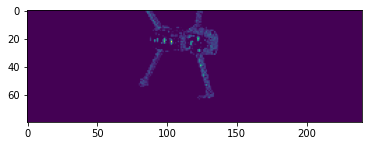

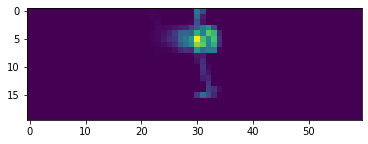

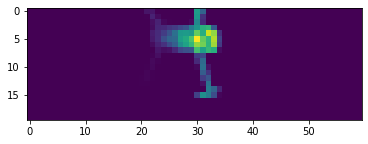

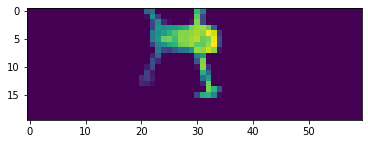

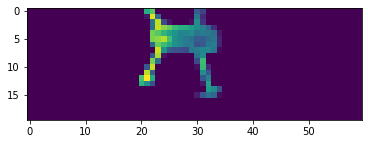

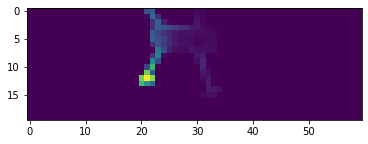

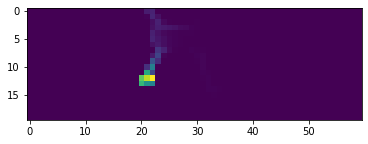

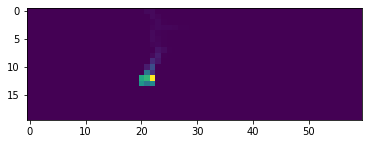

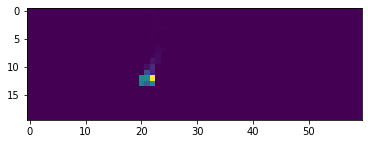

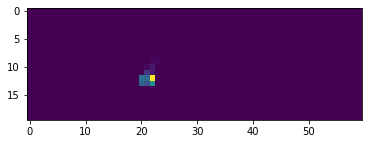

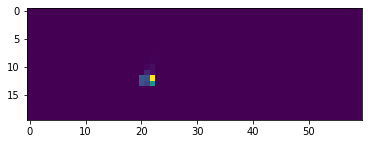

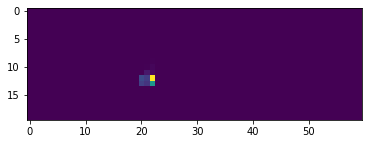

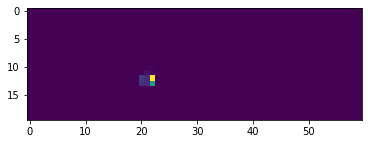

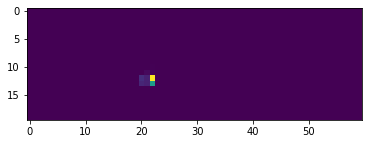

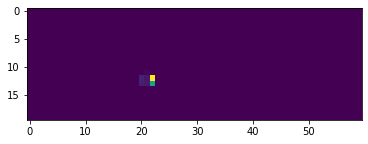

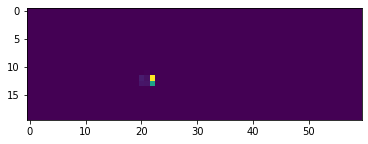

In [2]:

#Training and testing data for a single drone
train_inten_DATADIR = "/Put_File_Path_Here/Training/Intensity/"
train_label_DATADIR = "/Put_File_Path_Here/Training/Labels/"
train_depth_DATADIR = "/Put_File_Path_Here/Training/Depth/"

test_inten_DATADIR = "/Put_File_Path_Here/Testing/Intensity/"
test_label_DATADIR = "/Put_File_Path_Here/Testing/Labels/"
test_depth_DATADIR = "/Put_File_Path_Here/Testing/Depth/"


inten_training_data = np.zeros((68399,80,240,1))
inten_testing_data = np.zeros((3600,80,240,1))

start_number_inten_imgs = 1
end_number_inten_imgs = 71999

test_imgs = range(1,3600+1,1)

def create_iten_data():
    count_1 = 0
    count_2 = 0
    for i in tqdm(range(start_number_inten_imgs,end_number_inten_imgs+1,1)):
        
        if i in test_imgs:

            path_0 = test_inten_DATADIR+str(i)+".bmp"
            img_array = cv2.imread(path_0 ,cv2.IMREAD_GRAYSCALE)
            new_array = img_array[40:120,0:240]
            inten_testing_data[count_1,:,:,0] = new_array
            count_1 = count_1+1    
        else:

            path_0 = train_inten_DATADIR+str(i)+".bmp"
            img_array = cv2.imread(path_0 ,cv2.IMREAD_GRAYSCALE)
            new_array = img_array[40:120,0:240]
            inten_training_data[count_2,:,:,0] = new_array
            count_2 = count_2+1


create_iten_data()


depth_training_data = np.zeros((68399,20,60,15,1))
depth_testing_data = np.zeros((3600,20,60,15,1))

depth_img_original_r = 32
depth_img_original_c = 64 

def create_depth_data():
    count_1 = 0
    count_2 = 0
    for i in tqdm(range(start_number_inten_imgs,end_number_inten_imgs+1,1)):
        
        if i in test_imgs:

            path_0 = test_depth_DATADIR+str(i)+".csv"

            histo_array = np.loadtxt(path_0, delimiter=',', usecols=range(15))# convert to array
            histo_array = np.reshape(histo_array,(depth_img_original_r,depth_img_original_c,15), order="F") #order "F" means fortran like, makes it work like matlab reshape
            new_array = histo_array[10:30,0:60,:]#adjust image size to match SPAD data

            depth_testing_data[count_1,:,:,:,0] = new_array
            count_1 = count_1+1    
        else:

            path_0 = train_depth_DATADIR+str(i)+".csv"

            histo_array = np.loadtxt(path_0, delimiter=',', usecols=range(15))# convert to array
            histo_array = np.reshape(histo_array,(depth_img_original_r,depth_img_original_c,15), order="F") #order "F" means fortran like, makes it work like matlab reshape
            new_array = histo_array[10:30,0:60,:]#adjust image size to match SPAD data

            depth_training_data[count_2,:,:,:,0] = new_array
            count_2 = count_2+1


create_depth_data()# Only run once

np.save('depth_training_data.npy', depth_training_data) # saves the histogram array which is slow to generate
np.save('depth_testing_data.npy', depth_testing_data)

depth_training_data = np.load('depth_training_data.npy')
depth_testing_data = np.load('depth_testing_data.npy')

train_yaw_labels = np.zeros((68399,1))
test_yaw_labels = np.zeros((3600,1))

train_roll_labels = np.zeros((68399,1))
test_roll_labels = np.zeros((3600,1))

train_pitch_labels = np.zeros((68399,1))
test_pitch_labels = np.zeros((3600,1))

def create_labels():
    count_1 = 0
    count_2 = 0
    for i in tqdm(range(start_number_inten_imgs,end_number_inten_imgs+1,1)):
        
        if i in test_imgs:

            path_0 = test_label_DATADIR+str(i)+".csv"

            label_array = np.loadtxt(path_0, delimiter=',', usecols=range(1))# convert to array
            test_yaw_labels[count_1,:] = label_array[0]
            test_roll_labels[count_1,:] = label_array[1]
            test_pitch_labels[count_1,:] = label_array[2]

            count_1 = count_1+1    
        else:

            path_0 = train_label_DATADIR+str(i)+".csv"

            label_array = np.loadtxt(path_0, delimiter=',', usecols=range(1))# convert to array
            train_yaw_labels[count_2,:] = label_array[0]
            train_roll_labels[count_2,:] = label_array[1]
            train_pitch_labels[count_2,:] = label_array[2]
            count_2 = count_2+1


create_labels()

#uncomment lines below to view training data

#plt.imshow(inten_training_data[400,:,:,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,0,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,1,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,2,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,3,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,4,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,5,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,6,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,7,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,8,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,9,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,10,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,11,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,12,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,13,0]*20.0)
#plt.show()
#plt.imshow(depth_training_data[400,:,:,14,0]*20.0)
#plt.show()

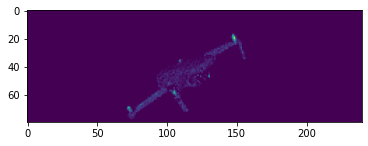

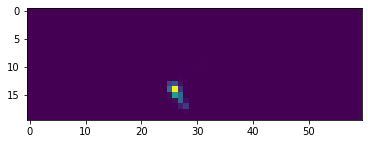

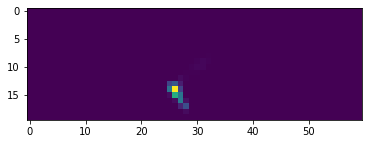

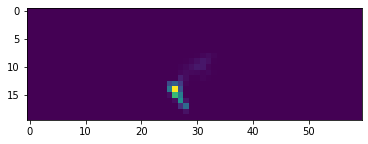

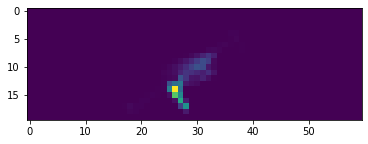

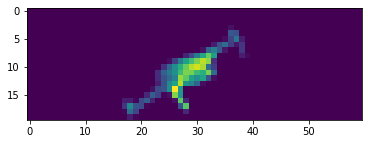

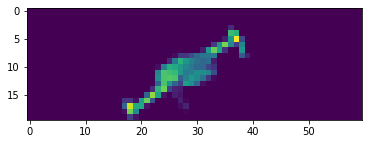

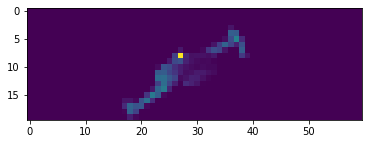

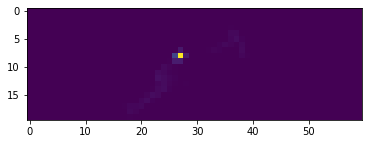

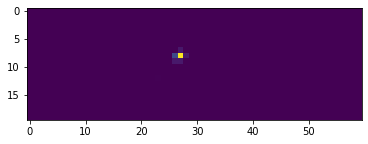

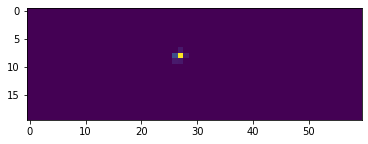

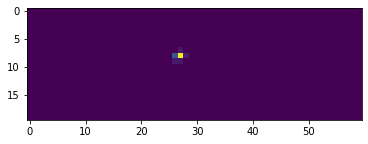

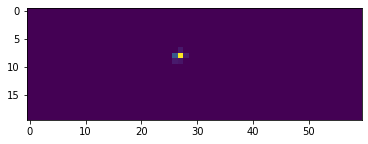

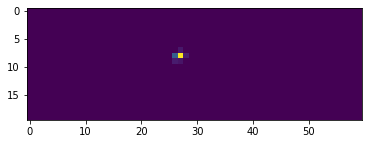

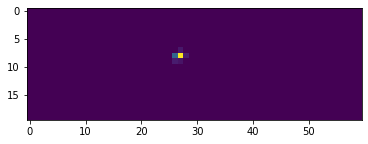

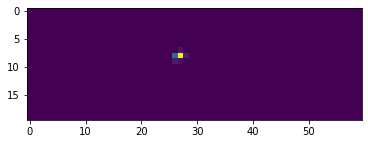

[124.544842]
#


In [3]:
#Shuffle training data
randomize = np.arange(len(train_roll_labels))

np.random.shuffle(randomize)

inten_training_data = inten_training_data[randomize]
depth_training_data = depth_training_data[randomize]
train_roll_labels = train_roll_labels[randomize]
train_yaw_labels = train_yaw_labels[randomize]
train_pitch_labels = train_pitch_labels[randomize]

#View training data
plt.imshow(inten_training_data[500,:,:,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,0,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,1,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,2,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,3,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,4,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,5,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,6,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,7,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,8,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,9,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,10,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,11,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,12,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,13,0]*20.0)
plt.show()
plt.imshow(depth_training_data[500,:,:,14,0]*20.0)
plt.show()


In [4]:
#Bespoke Loss and Error functions for angular prediction

def Custom_Loss(truth, guess):


    loss = (guess-truth)**2

    loss = K.minimum(loss,((guess-truth)-360.0)**2)

    return loss    


def Custom_Error(truth,guess):
    
    acc = K.abs(guess-truth)
    acc = K.minimum(acc,K.abs((guess-truth)-360.0))    

    return acc


In [5]:
#Yaw prediction network

#wandb.init(project="W_N_I_A_H_O_B_O_W_M_C_A_C_L_M_A",config={"hyper": "parameter"}) # initialize weights and biases if in use

yaw_depth_inputs = Input(shape = (20,60,15,1))#20x60x15x1
yaw_depth_C1 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(yaw_depth_inputs)
yaw_depth_C2 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(yaw_depth_C1)

print(yaw_depth_C1.shape)
yaw_depth_MP_1 = MaxPooling3D(pool_size=(1, 1,3),padding='same')(yaw_depth_C2)
print(yaw_depth_MP_1.shape)
yaw_depth_C4 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(yaw_depth_MP_1)
yaw_depth_C5 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(yaw_depth_C4)

yaw_depth_MP_2 = MaxPooling3D(pool_size=(1, 1,5),padding='same')(yaw_depth_C5)
print(yaw_depth_MP_2.shape)
yaw_depth_MP_2 = squeeze(yaw_depth_MP_2,3)
print(yaw_depth_MP_2.shape)

yaw_inten_inputs = Input(shape = (80,240,1))#80x240x1
yaw_inten_C1 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(yaw_inten_inputs)
yaw_inten_C2 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(yaw_inten_C1)

print(yaw_inten_C1.shape)
yaw_inten_MP_1 = MaxPooling2D(pool_size=(4, 4),padding='same')(yaw_inten_C2)
print(yaw_inten_MP_1.shape)

yaw_joined = concatenate([yaw_inten_MP_1,yaw_depth_MP_2],axis=3)
print(yaw_joined.shape)


yaw_joined_C1 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(yaw_joined)
yaw_joined_C2 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(yaw_joined_C1)

print(yaw_inten_C1.shape)
yaw_joined_MP_1 = MaxPooling2D(pool_size=(4, 4),padding='same')(yaw_joined_C2)
print(yaw_joined_MP_1.shape)
yaw_joined_C4 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(yaw_joined_MP_1)
yaw_joined_C5 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(yaw_joined_C4)

print(yaw_joined_C2.shape)
yaw_joined_MP_2 = MaxPooling2D(pool_size=(5, 5),padding='same')(yaw_joined_C5)

print(yaw_joined_MP_2.shape)

yaw_final_flat = Flatten()(yaw_joined_MP_2)

yaw_dense_1 = Dense(64,activation='relu')(yaw_final_flat)

yaw = Dense(1,activation='relu')(yaw_dense_1)

yaw_model = Model(inputs = [yaw_inten_inputs,yaw_depth_inputs],outputs = [yaw])

print(yaw_model.summary())

yaw_model.compile(loss=Custom_Loss,optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),metrics=[Custom_Error])

checkpoint_filepath = '/Your_File_Path_Here/Yaw'# filepath for model checkpoints


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_Custom_Error', mode='min', save_best_only=True)

yaw_model.fit([inten_training_data,depth_training_data], [train_yaw_labels], batch_size=128, epochs=100,validation_data=([inten_testing_data,depth_testing_data], [test_yaw_labels]), callbacks=[model_checkpoint_callback])

K.clear_session()# Helps prevent GPU memory leakage

(None, 20, 60, 15, 32)
(None, 20, 60, 5, 32)
(None, 20, 60, 1, 32)
(None, 20, 60, 32)
(None, 80, 240, 32)
(None, 20, 60, 32)
(None, 20, 60, 64)
(None, 80, 240, 32)
(None, 5, 15, 32)
(None, 20, 60, 32)
(None, 1, 3, 32)
68399
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 60, 15,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 20, 60, 15, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 20, 60, 15, 3 27680       conv3d[0][0]                     
____________________________________________________________________

In [6]:
#Roll network, functionally identical to Yaw network.

#wandb.init(project="W_N_I_A_H_Y_R_A_P_W_M_C_A_C_L",config={"hyper": "parameter"})

roll_depth_inputs = Input(shape = (20,60,15,1))#20x60x15x1
roll_depth_C1 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(roll_depth_inputs)
roll_depth_C2 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(roll_depth_C1)

print(roll_depth_C1.shape)
roll_depth_MP_1 = MaxPooling3D(pool_size=(1, 1,3),padding='same')(roll_depth_C2)
print(roll_depth_MP_1.shape)
roll_depth_C4 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(roll_depth_MP_1)
roll_depth_C5 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(roll_depth_C4)

roll_depth_MP_2 = MaxPooling3D(pool_size=(1, 1,5),padding='same')(roll_depth_C5)
print(roll_depth_MP_2.shape)
roll_depth_MP_2 = squeeze(roll_depth_MP_2,3)
print(roll_depth_MP_2.shape)

roll_inten_inputs = Input(shape = (80,240,1))#80x240x1
roll_inten_C1 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(roll_inten_inputs)
roll_inten_C2 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(roll_inten_C1)

print(roll_inten_C1.shape)
roll_inten_MP_1 = MaxPooling2D(pool_size=(4, 4),padding='same')(roll_inten_C2)
print(roll_inten_MP_1.shape)

roll_joined = concatenate([roll_inten_MP_1, roll_depth_MP_2],axis=3)
print(roll_joined.shape)


roll_joined_C1 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(roll_joined)
roll_joined_C2 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(roll_joined_C1)

print(roll_inten_C1.shape)
roll_joined_MP_1 = MaxPooling2D(pool_size=(4, 4),padding='same')(roll_joined_C2)
print(roll_joined_MP_1.shape)
roll_joined_C4 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(roll_joined_MP_1)
roll_joined_C5 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(roll_joined_C4)

print(roll_joined_C2.shape)
roll_joined_MP_2 = MaxPooling2D(pool_size=(5, 5),padding='same')(roll_joined_C5)


print(roll_joined_MP_2.shape)

roll_final_flat = Flatten()(roll_joined_MP_2)

roll_dense_1 = Dense(64,activation='relu')(roll_final_flat)

roll = Dense(1,activation='relu' )(roll_dense_1)

roll_model = Model(inputs = [roll_inten_inputs,roll_depth_inputs],outputs = [roll])

print(roll_model.summary())

roll_model.compile(loss=Custom_Loss,optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),metrics=[Custom_Error])

checkpoint_filepath = '/Your_File_Path_Here/Roll'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_Custom_Error', mode='min', save_best_only=True)

roll_model.fit([inten_training_data,depth_training_data], [train_roll_labels], batch_size=128, epochs=100,validation_data=([inten_testing_data,depth_testing_data], [test_roll_labels]), callbacks=[model_checkpoint_callback])

K.clear_session()

(None, 20, 60, 15, 32)
(None, 20, 60, 5, 32)
(None, 20, 60, 1, 32)
(None, 20, 60, 32)
(None, 80, 240, 32)
(None, 20, 60, 32)
(None, 20, 60, 64)
(None, 80, 240, 32)
(None, 5, 15, 32)
(None, 20, 60, 32)
(None, 1, 3, 32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 60, 15,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 20, 60, 15, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 20, 60, 15, 3 27680       conv3d[0][0]                     
__________________________________________________________________________

In [7]:
#Pitch network, functionally identical to Yaw network

#wandb.init(project="W_N_I_A_H_Y_R_A_P_W_M_C_A_C_L",config={"hyper": "parameter"})

pitch_depth_inputs = Input(shape = (20,60,15,1))#20x60x15x1
pitch_depth_C1 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(pitch_depth_inputs)
pitch_depth_C2 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(pitch_depth_C1)

print(pitch_depth_C1.shape)
pitch_depth_MP_1 = MaxPooling3D(pool_size=(1, 1,3),padding='same')(pitch_depth_C2)
print(pitch_depth_MP_1.shape)
pitch_depth_C4 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(pitch_depth_MP_1)
pitch_depth_C5 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(pitch_depth_C4)

pitch_depth_MP_2 = MaxPooling3D(pool_size=(1, 1,5),padding='same')(pitch_depth_C5)
print(pitch_depth_MP_2.shape)
pitch_depth_MP_2 = squeeze(pitch_depth_MP_2,3)
print(pitch_depth_MP_2.shape)

pitch_inten_inputs = Input(shape = (80,240,1))#80x240x1
pitch_inten_C1 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(pitch_inten_inputs)
pitch_inten_C2 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(pitch_inten_C1)

print(pitch_inten_C1.shape)
pitch_inten_MP_1 = MaxPooling2D(pool_size=(4, 4),padding='same')(pitch_inten_C2)
print(pitch_inten_MP_1.shape)

pitch_joined = concatenate([pitch_inten_MP_1, pitch_depth_MP_2],axis=3)
print(pitch_joined.shape)


pitch_joined_C1 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(pitch_joined)
pitch_joined_C2 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(pitch_joined_C1)

print(pitch_inten_C1.shape)
pitch_joined_MP_1 = MaxPooling2D(pool_size=(4, 4),padding='same')(pitch_joined_C2)
print(pitch_joined_MP_1.shape)
pitch_joined_C4 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(pitch_joined_MP_1)
pitch_joined_C5 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(pitch_joined_C4)

print(pitch_joined_C2.shape)
pitch_joined_MP_2 = MaxPooling2D(pool_size=(5, 5),padding='same')(pitch_joined_C5)


print(pitch_joined_MP_2.shape)

pitch_final_flat = Flatten()(pitch_joined_MP_2)

pitch_dense_1 = Dense(64,activation='relu')(pitch_final_flat)

pitch = Dense(1,activation='relu' )(pitch_dense_1)

pitch_model = Model(inputs = [pitch_inten_inputs,pitch_depth_inputs],outputs = [pitch])

print(pitch_model.summary())

pitch_model.compile(loss=Custom_Loss,optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),metrics=[Custom_Error])

checkpoint_filepath = '/Your_File_Path_Here/Pitch'


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_Custom_Error', mode='min', save_best_only=True)

pitch_model.fit([inten_training_data,depth_training_data], [train_pitch_labels], batch_size=128, epochs=100,validation_data=([inten_testing_data,depth_testing_data], [test_pitch_labels]), callbacks=[model_checkpoint_callback])

K.clear_session()

(None, 20, 60, 15, 32)
(None, 20, 60, 5, 32)
(None, 20, 60, 1, 32)
(None, 20, 60, 32)
(None, 80, 240, 32)
(None, 20, 60, 32)
(None, 20, 60, 64)
(None, 80, 240, 32)
(None, 5, 15, 32)
(None, 20, 60, 32)
(None, 1, 3, 32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 60, 15,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 20, 60, 15, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 20, 60, 15, 3 27680       conv3d[0][0]                     
__________________________________________________________________________